接下来我们来讨论一下语义分割
* 实际上从图像分类，到物体检测、语义分割，是一个层层递进的关系
* 在物体检测中，我们是用一个bbox来把我们想要的物体给框起来，虽然说这能尽量规定好我们所需要的物体的范围，但是这仍然存在一定的偏差
* 另一方面，在某些实际应用，比如无人车上，我们想要探测到的物体其实并不是一个具有非常标准形状的物体，比如说无人车检测不同的道路，一旦开错一点就有可能造成车祸
* 语义分割实际上就是在bbox上面更进一步，我们对每个像素进行类别标注，这样我们就可以知道，非常准确的物体位置信息了

在语义分割问题中，最为常用的学术界数据集是Pascal VOC2012

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
#@save
# 这里就是把所有的给读进来，然后把标注信息给弄上去（以RGB的形式）
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)
# 实际上这里训练数据集是一张张图片，对应的label也是同样大小的图片，只不过用rgb色彩来进行分割

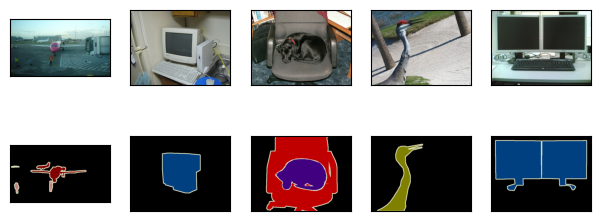

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);
# 可以发现，就是不同RGB颜色来对应不同的物体

In [5]:
# 这里就是不同RGB和最终类别的对应关系
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
# 这里我们分别定义了两个辅助函数
# 因为rgb值其实是一个三元的元组，所以我们这里把他全都展开，然后通过一个换算公式把rgb值给合到一起（这个换算公式挺有意思的）
# 这样我们rgb值（也就是单一的一个值）就能和类别达成一一对应的关系了
# 第二个函数其实就是把label里面的读进来，因为label里面存的是rgb像素值，然后我们通过上面的换算公式（voc_colormap2label），换算到我们对应的是啥类别
#@save
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
        # 这个算法其实就是tupple换算成整型，这样可以防止用Python for loop去查找
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]
# 这里的01其实就是对应背景和第一个类别，aeroplane

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

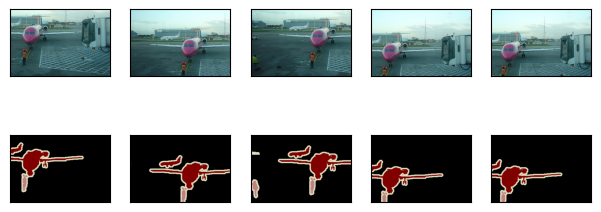

In [8]:
# 这里我们来研究怎么对语义分割/目标检测数据集做随机裁剪来进行数据增广
# 原来在图像分类里面，增广其实是比较好做的，因为你随便裁剪一下是没啥问题的
# 但是在语义分割或者是目标检测数据集里面，随便裁剪可能把东西给弄没了
#@save
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    # 这里我们调用了一个get_params函数，这个函数允许我们在裁剪相应大小的图片的时候，同时保持图片中相应的bbox
    # 其实也就是，图片自身要这样裁剪、label也要这样裁剪
    # 也有一个定义随机因子的作用
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    # 然后我们把rect这个框给扔进真正的裁剪函数里面去，就可以保留物体从而进行裁剪了
    # print(rect)
    # 这里返回的是一个(46, 118, 200, 300)这样的数组，后两个是相应的大小，前面就是我们需要的裁剪的特定位置信息
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [9]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    # crop的作用其实也有一个resize一个作用
    # 因为voc每个图片大小不太一样，针对图片分类我们当然可以直接调用resize就这么过去了
    # 但是在voc数据里面如果单单针对图片做resize（图片resize是通过插值做），那label其实不太方便去做resize（因为像素一一对应的，插值并不能做label的插值）
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #　这里还是为了后面能使用imageNet的pretrain model，所以做同样的处理
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        # 这里我们下面定义了一个filter函数来调用
        # 这里其实就是，如果你图片比我corp的大小还要小，我就不要了
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        # 加载我们之前弄出来的voc_colormap2label
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    # 这下面和前面类似的，是torch里面对DataSet的要求
    # 拿到某个样本，返回相应的Xy
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [10]:
crop_size = (320, 480) # 这是我们人为定的，差不多都是这个大小吧
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [11]:
# 这里和之前是一样的，用DataLoader去读取生成迭代器
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

# 这里可以发现，语义分割和最初的图像识别的数据形式差别主要是在y上
# X还是四个维度，批量、通道、面积
# 语义分割中y则变成了3个维度（图像分类是2个），批量和面积
# 因为我们这里的标号肯定是一一对应的，在像素上

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [12]:
# 这里就是个缝合函数
#@save
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter